## Import library

In [1]:
import skfmm
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import random
from matplotlib.gridspec import GridSpec

random.seed(202510)

## Load data

In [2]:
train_data = np.load('./data/train_vel.npy')
test_data = np.load('./data/test_vel.npy')

## Generate random index to select data from each vel family 

In [3]:
numbers = random.sample(range(501), 50)
print(f"Selected random indices: {numbers}")

Selected random indices: [41, 353, 32, 167, 15, 150, 94, 71, 23, 40, 86, 390, 384, 264, 61, 85, 197, 243, 359, 185, 392, 482, 448, 251, 310, 209, 365, 122, 11, 309, 302, 235, 216, 484, 444, 67, 145, 106, 258, 432, 44, 203, 331, 398, 496, 334, 483, 42, 393, 90]


## Select for training 

In [4]:
selected_train_vel = []

num_channels_to_select = 3
for ii in range(0, min(num_channels_to_select, train_data.shape[1])):
    data = train_data[:, ii, :, :]
    for idx in numbers:
        selected_data = data[idx, :, :]/1000
        selected_train_vel.append(selected_data)

selected_train_vel = np.array(selected_train_vel)
# Expected shape: (50 indices * 3 channels, 70, 70) = (150, 70, 70)
print(f"Selected train velocity shape: {selected_train_vel.shape}")
np.save('./data/selected_vel_train.npy', selected_train_vel)

Selected train velocity shape: (150, 70, 70)


## Select for testing

In [5]:
selected_test_vel = []
for ii in range(0, 1):
    data = test_data[:, ii, :, :]
    for idx in numbers:
        selected_data = data[idx, :, :]/1000
        selected_test_vel.append(selected_data)

selected_test_vel = np.array(selected_test_vel)
# Expected shape: (50 indices * 1 channel, 70, 70) = (50, 70, 70)
print(f"Selected test velocity shape: {selected_test_vel.shape}")
np.save('./data/selected_vel_test.npy', selected_test_vel)

Selected test velocity shape: (50, 70, 70)


## T and T0 for training data

In [6]:
ns = 10
deltax = 0.01
deltaz = 0.01
SX = np.array([(j * 7 + 1) * deltax for j in range(ns)])  # Source x positions
SZ = np.zeros(ns)  # Source z positions (all at top)
X, Z = np.meshgrid(np.arange(70) * deltax, np.arange(70) * deltaz)  # Receiver grid (X along columns, Z along rows)

# Lists to collect all T and T0
all_Tdata = []
all_T0data = []


# Travel Time Calculation (skfmm) for training
for i in range(selected_train_vel.shape[0]):
    vel = selected_train_vel[i, :, :]
    # vels = gaussian_filter(vel, sigma=1) # Keep the original velocity as requested by setting vels=vel
    vels = vel
    
    Tdata_list = []
    # T_data (FMM) calculation
    for j in range(ns):
        phi = np.ones(vel.shape)
        # Source position at top row (0), column matching x_idxs from SX
        phi[0, j * 7 + 1] = 0
        
        # skfmm.travel_time is calculated using the Eikonal equation: |grad T| = 1/v
        t = skfmm.travel_time(phi, vels, dx=deltax) # Assuming deltax = deltaz = 0.01
        Tdata_list.append(t)
    
    Tdata = np.asarray(Tdata_list)
    all_Tdata.append(Tdata)
    
    T0data_list = []
    # T0_data (Homogeneous Background approximation) calculation
    z_idxs = np.round(SZ / deltaz).astype(int)
    x_idxs = np.round(SX / deltax).astype(int)
    # vs: Velocities at source locations, shape (ns,)
    # The original code used indices corresponding to the FMM source definition (0, j*7+1)
    # The array indices are (row, column) = (z_index, x_index). z_idxs[j]=0
    vs = vel[z_idxs, x_idxs] 
    
    for j in range(ns):
        # Compute distances from source j to all receivers (R)
        dist = np.sqrt((Z - SZ[j])**2 + (X - SX[j])**2)
        # T0 = R / v_s, where v_s is the velocity at the source point
        T0 = dist / vs[j]
        T0data_list.append(T0)
    
    T0data = np.asarray(T0data_list)
    all_T0data.append(T0data)

# Stack all into single arrays
# Final shape: (150 models, 10 sources, 70 z-points, 70 x-points)
all_Tdata = np.stack(all_Tdata, axis=0)
all_T0data = np.stack(all_T0data, axis=0)

# The expected shape is (150, 10, 70, 70) - Note: axes are (model, source, Z, X)
print(f"T data shape: {all_Tdata.shape}, T0 data shape: {all_T0data.shape}")

# Save to numpy files
np.save('./data/Tdata_train.npy', all_Tdata)
np.save('./data/T0data_train.npy', all_T0data)

T data shape: (150, 10, 70, 70), T0 data shape: (150, 10, 70, 70)


## Training data vsualization


Selected random model index for plotting: 65


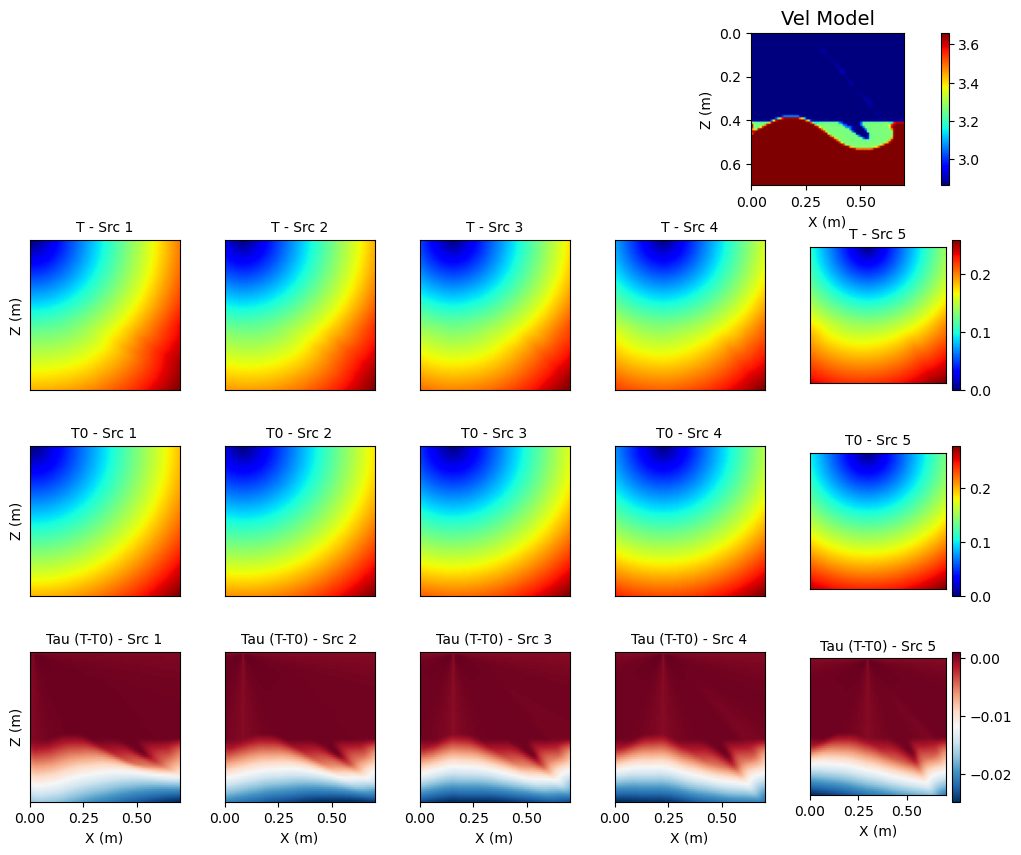

In [10]:
random_idx = random.randint(0, all_Tdata.shape[0] - 1)
print(f'\nSelected random model index for plotting: {random_idx}')

# Extract data for this model
vel = selected_train_vel[random_idx, :, :]
# T, T0, tau are extracted as (10 sources, 70 Z, 70 X)
T_full = all_Tdata[random_idx, :, :, :]
T0_full = all_T0data[random_idx, :, :, :]
tau_full = (all_Tdata - all_T0data)[random_idx, :, :, :]


T = T_full 
T0 = T0_full
tau = tau_full



# Create figure with GridSpec for uneven row heights (vel larger)
fig = plt.figure(figsize=(12, 10)) # Increased height for better visualization

# FIX: Changed height_ratios to make the velocity row (index 0) twice as tall
gs = GridSpec(4, 5, height_ratios=[1, 1, 1, 1], hspace=0.35, wspace=0.3)

# First row: Velocity model (spanning the row)
ax_vel = fig.add_subplot(gs[0, :])
im_vel = ax_vel.imshow(vel, cmap='jet', aspect='equal', extent=[0, 70*deltax, 70*deltaz, 0])
ax_vel.set_title('Vel Model', fontsize=14)
ax_vel.set_xlabel('X (m)')
ax_vel.set_ylabel('Z (m)')
fig.colorbar(im_vel, ax=ax_vel, orientation='vertical', fraction=0.02, pad=0.04)


# Second row: First 5 T
for j in range(5):
    ax = fig.add_subplot(gs[1, j])
    im = ax.imshow(T[j, :, :], cmap='jet', aspect='equal', extent=[0, 70*deltax, 70*deltaz, 0])
    ax.set_title(f'T - Src {j+1}', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0: ax.set_ylabel('Z (m)')
    if j == 4: fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)


# Third row: First 5 T0
for j in range(5):
    ax = fig.add_subplot(gs[2, j])
    im = ax.imshow(T0[j, :, :], cmap='jet', aspect='equal', extent=[0, 70*deltax, 70*deltaz, 0])
    ax.set_title(f'T0 - Src {j+1}', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0: ax.set_ylabel('Z (m)')
    if j == 4: fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)

# Fourth row: First 5 tau (T - T0)
for j in range(5):
    ax = fig.add_subplot(gs[3, j])
    im = ax.imshow(tau[j, :, :], cmap='RdBu_r', aspect='equal', extent=[0, 70*deltax, 70*deltaz, 0])
    ax.set_title(f'Tau (T-T0) - Src {j+1}', fontsize=10)
    ax.set_xlabel('X (m)')
    # ax.set_xticks(np.linspace(0, 70*deltax, 4))
    ax.set_yticks([])
    if j == 0: 
        ax.set_ylabel('Z (m)')
        # ax.set_yticks(np.linspace(0, 70*deltaz, 4))
    if j == 4: fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)

plt.savefig(f'./figs/train_data_visual_{random_idx}.png', dpi=300)
plt.show()

## T and T0 for testing data

In [11]:
ns = 10
deltax = 0.01
deltaz = 0.01
SX = np.array([(j * 7 + 1) * deltax for j in range(ns)])  # Source x positions
SZ = np.zeros(ns)  # Source z positions (all at top)
X, Z = np.meshgrid(np.arange(70) * deltax, np.arange(70) * deltaz)  # Receiver grid

# Lists to collect all T and T0
all_Tdata = []
all_T0data = []

# Travel Time Calculation (skfmm) testing data
for i in range(selected_test_vel.shape[0]):
    vel = selected_test_vel[i, :, :]
    vels = vel # Use actual velocity for FMM
    
    Tdata_list = []
    # T_data (FMM) calculation
    for j in range(ns):
        phi = np.ones(vel.shape)
        # Source position at top row (0), column matching x_idxs
        phi[0, j * 7 + 1] = 0
        t = skfmm.travel_time(phi, vels, dx=deltax)
        Tdata_list.append(t)
    
    Tdata = np.asarray(Tdata_list)
    all_Tdata.append(Tdata)
    
    T0data_list = []
    # T0_data (Homogeneous Background approximation) calculation
    z_idxs = np.round(SZ / deltaz).astype(int)
    x_idxs = np.round(SX / deltax).astype(int)
    vs = vel[z_idxs, x_idxs]  # Velocities at source locations, shape (ns,)
    
    for j in range(ns):
        # Compute distances from source j to all receivers
        dist = np.sqrt((Z - SZ[j])**2 + (X - SX[j])**2)
        T0 = dist / vs[j]
        T0data_list.append(T0)
    
    T0data = np.asarray(T0data_list)
    all_T0data.append(T0data)

# Stack all into single arrays
# Final shape: (50 models, 10 sources, 70 Z, 70 X)
all_Tdata = np.stack(all_Tdata, axis=0)
all_T0data = np.stack(all_T0data, axis=0)

# Save to numpy files
np.save('./data/Tdata_test.npy', all_Tdata)
np.save('./data/T0data_test.npy', all_T0data)

print(f"Final T data shape: {all_Tdata.shape}, Final T0 data shape: {all_T0data.shape}")

Final T data shape: (50, 10, 70, 70), Final T0 data shape: (50, 10, 70, 70)


## Testing data visualization 


Selected random model index: 19


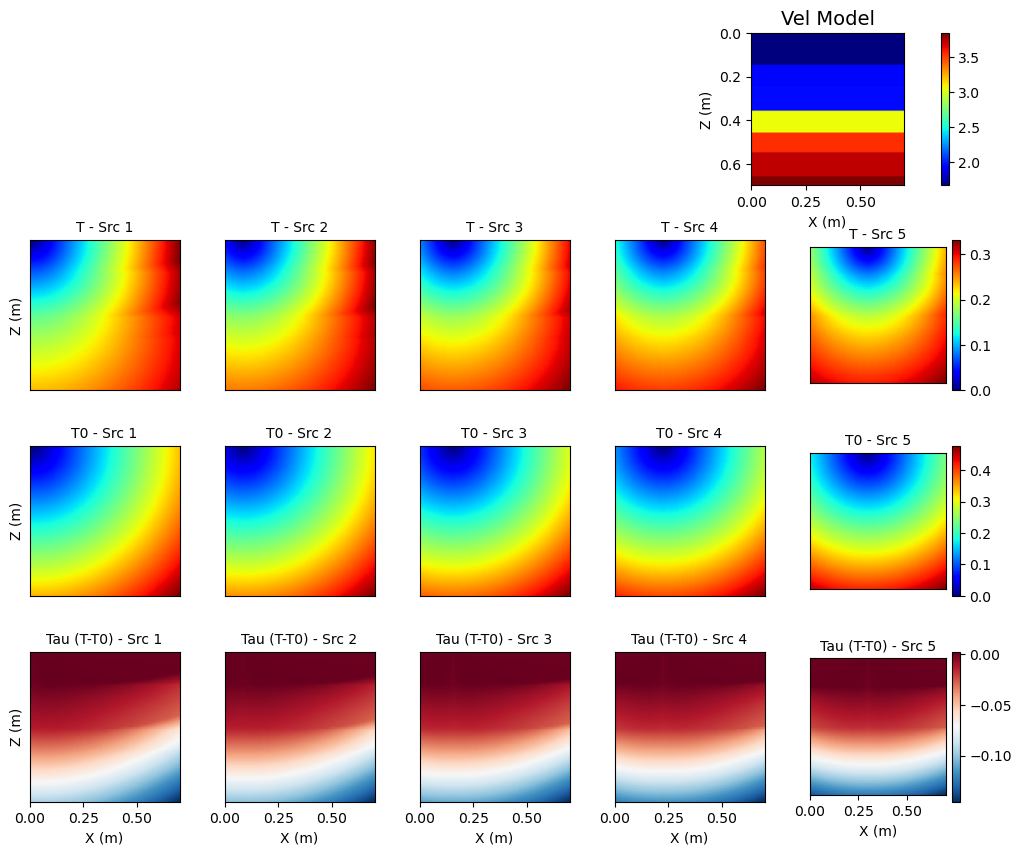

In [13]:
random_idx = random.randint(0, all_Tdata.shape[0] - 1)
print(f'\nSelected random model index: {random_idx}')

# Extract data for this model
vel = selected_test_vel[random_idx, :, :]

# T, T0, tau are extracted as (10 sources, 70 Z, 70 X)
T_full = all_Tdata[random_idx, :, :, :]
T0_full = all_T0data[random_idx, :, :, :]
tau_full = T_full - T0_full


T = T_full 
T0 = T0_full
tau = tau_full


# Create figure with GridSpec
fig = plt.figure(figsize=(12, 10)) # Increased height for better visualization

# DEBUG FIX/IMPROVEMENT: Adjusted height_ratios to make the velocity row (index 0) taller
gs = GridSpec(4, 5, height_ratios=[1, 1, 1, 1], hspace=0.35, wspace=0.3) 

# Calculate extent using deltax/deltaz for proper scale
extent_vals = [0, 70 * deltax, 70 * deltaz, 0] # [xmin, xmax, ymax, ymin]

# First row: Velocity model (spanning the row)
ax_vel = fig.add_subplot(gs[0, :])
im_vel = ax_vel.imshow(vel, cmap='jet', aspect='equal', extent=extent_vals)
ax_vel.set_title('Vel Model', fontsize=14)
ax_vel.set_xlabel('X (m)')
ax_vel.set_ylabel('Z (m)')
fig.colorbar(im_vel, ax=ax_vel, orientation='vertical', fraction=0.02, pad=0.04)

# Second row: First 5 T
for j in range(5):
    ax = fig.add_subplot(gs[1, j])
    im = ax.imshow(T[j, :, :], cmap='jet', aspect='equal', extent=extent_vals)
    ax.set_title(f'T - Src {j+1}', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0: ax.set_ylabel('Z (m)')
    if j == 4: fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)

# Third row: First 5 T0
for j in range(5):
    ax = fig.add_subplot(gs[2, j])
    im = ax.imshow(T0[j, :, :], cmap='jet', aspect='equal', extent=extent_vals)
    ax.set_title(f'T0 - Src {j+1}', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0: ax.set_ylabel('Z (m)')
    if j == 4: fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)

# Fourth row: First 5 tau (T - T0)
for j in range(5):
    ax = fig.add_subplot(gs[3, j])
    im = ax.imshow(tau[j, :, :], cmap='RdBu_r', aspect='equal', extent=extent_vals)
    ax.set_title(f'Tau (T-T0) - Src {j+1}', fontsize=10)
    ax.set_xlabel('X (m)')
    # ax.set_xticks(np.linspace(0, 70*deltax, 4))
    ax.set_yticks([])
    if j == 0: 
        ax.set_ylabel('Z (m)')
        # ax.set_yticks(np.linspace(0, 70*deltaz, 4))
    if j == 4: fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)

plt.savefig(f'./figs/test_data_visual_{random_idx}.png', dpi=300)
plt.show()